# DELE ST1504 CA2
# PART B: RL

<hr>

**NAME**: Irman Zafyree, Adam Tan

**ADMIN NO**: `2300546`, `2300575`

**CLASS**: DAAA/FT/2B/07

<hr>

**Objective:**

For our model to exert some appropriate torque on the pendulum to balance it.

**Background:**

A Deep Q-Network (DQN) is a reinforcement learning algorithm that combines Q-learning, a fundamental RL algorithm, with deep learning techniques. In this project, we will be using DQN to train our model to exert the right amount of torque on the pendulum to balance it.

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import ParameterGrid
import re
import skvideo.io
import moviepy.editor as mpy
from gym.wrappers import Monitor
import time

# Initial Set up

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [11]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 0.95,  # Discount rate
                 epsilon = 1.0,  # Exploration rate
                 epsilon_min = 0.1,
                 epsilon_decay = 0.995,
                 learning_rate = 0.01,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32,
                 optimizer = Adam()):
        
        # Hyperparameters. #
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        
        self.total_reward = 0  # Initialize total reward accumulator
        self.episode_rewards = []  # List to store rewards for each episode
        self.average_rewards = []
    


        # Main model. #
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = optimizer
        self.learning_rate = learning_rate

        
        # Target model. #
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory. #
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter. #
        
        self.TargetUpdateCounter = 0
    def reset_optimizer(self):
        """Reinitialize the optimizer with the same or new parameters."""
        self.optimizer = Adam(learning_rate=self.learning_rate)
        # You may need to compile your model again with the new optimizer.
        self.Main.compile(optimizer=self.optimizer, loss='mse')
        
    def save_weights(self, dir_path):
        print(f'Saving weights to {dir_path}')
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        Main_path = os.path.join(dir_path, 'Main')
        Target_path = os.path.join(dir_path, 'Target')
        self.Main.save_weights(Main_path + '_main.weights.h5')
        self.Target.save_weights(Target_path + '_target.weights.h5')
    
    
    def load_weights(self, path):
        print(f'Loading weights from {path}')
        Main_path = os.path.join(path, 'Main')
        Target_path = os.path.join(path, 'Target')
        self.Main.load_weights(Main_path + '_main.weights.h5')
        self.Target.load_weights(Target_path + '_target.weights.h5')

    def moving_average (self, values, window):
        weights = np.repeat(1.0, window)/window
        return np.convolve(values, weights, 'valid')
    
    def plot_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.episode_rewards, marker='o')
        plt.plot(self.moving_average(self.episode_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.show()

    def plot_avg_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.average_rewards, marker='o')
        plt.plot(self.moving_average(self.average_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)
        plt.show()


    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (state, action, reward, SNext, Done)
        self.ReplayMemory.append(Information)


    def Train(self, EndOfEpisode, reward):
        self.total_reward += reward  # Accumulate reward for the current episode

        # Only train if replay memory has enough data. #
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training. #
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values. #
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values. #
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network. #
        
        X = []
        Y = []
        for index, (state, action, reward, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = reward + self.Gamma * MaxQNext
            else:
                QNext = reward
            Q = ListOfQ[index]
            Q[action] = QNext
            X.append(state)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
    
        self.GTfit(X, Y)
                
        # Update target network every episode. #
        
        if EndOfEpisode:
            self.episode_rewards.append(self.total_reward)  # Store total reward for the episode
            self.total_reward = 0  # Reset total reward for the next episode
            self.TargetUpdateCounter += 1

        
        # Update target if counter is full. #
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0


    # This is the tf.GradientTape() which significantly speeds up training of neural networks
    @tf.function
    def GTfit(self, X, Y):
        
        # Train the neural network with this batch of data. #
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

In [4]:
EnvName = 'Pendulum-v0'
IntermediateSize = 64
Epsilon_min = 0.1
Epsilon_decay = 0.99
Epsilon = 1.0
ShowEvery = 10
InputShape = 3
NActions = 20

In [5]:
def PendulumActionConverter(action, NActions=NActions):
    ActualTorque = (action / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(action, NActions=NActions):
    ActualA = round((action + 2) * (NActions - 1) / 4)
    return(ActualA)

def OneEpisode(DQN, env):
    state = env.reset()
    ListOfRewards = []
    Done = False
    global Epsilon
    while not Done:
        Q = DQN.Main(state.reshape(-1, state.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            action = PendulumInverseActionConverter(AStep[0], DQN.NActions)
        else:
            action = np.argmax(Q)
            action = PendulumActionConverter(action)
            AStep = np.array([action])
            action = PendulumInverseActionConverter(action, DQN.NActions)
        #Epsilon *= Epsilon_decay 
        if not _ % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            env.render()

        SNext, reward, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((state, action, reward, SNext, Done))
        DQN.Train(Done, reward)
        ListOfRewards.append(reward)

        if Done:
            print(f'Finished! | Return: {np.sum(ListOfRewards)} | average reward: {np.mean(ListOfRewards)}')
            env.close()
   
            return ListOfRewards
        state = SNext

# Base model

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26

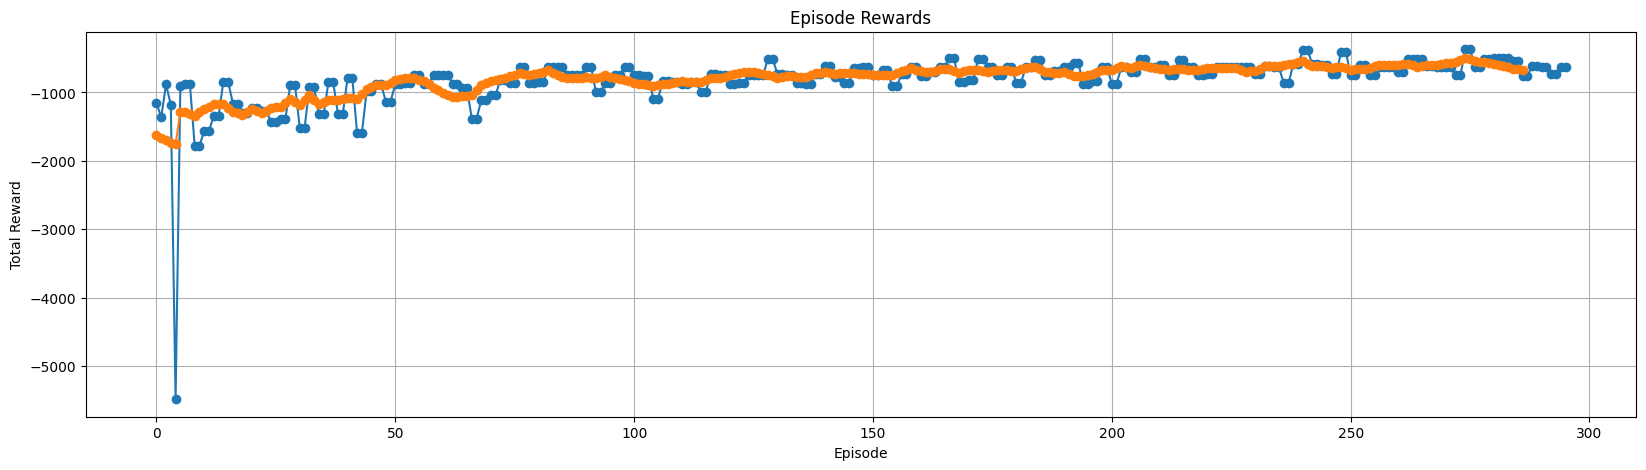

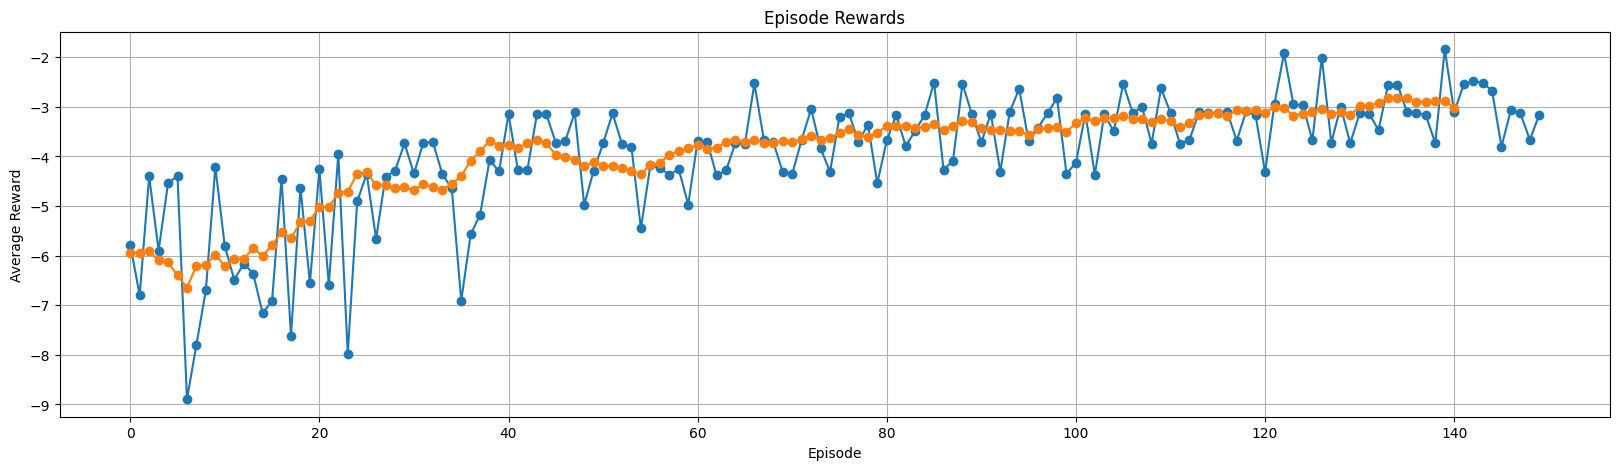

In [32]:
STARTTIME = time.time()
env = gym.make(f'{EnvName}')
env = Monitor(env,'./pendulum_Videos', force=True)
tf.keras.backend.clear_session()
dqn = DQN(InputShape = InputShape, NActions = NActions)
dqn.Main.compile(optimizer = dqn.optimizer, loss = 'mse')
dir_path='best_dqn_weights'
dqn.load_weights(path=dir_path)

Epsilon = 1.0
EPISODES = 150
best_reward = -1000
avg_reward = []
for _ in range(EPISODES):

    print(f'Episode {_}')
    reward = OneEpisode(dqn, env)
    
    if Epsilon > Epsilon_min:
        Epsilon *= Epsilon_decay 
        print('Epsilon:',Epsilon)

    dqn.episode_rewards.append(np.sum(reward))
    dqn.average_rewards.append(np.mean(reward))
    print(f'Best reward: {best_reward}')

    if np.mean(reward) > best_reward:
        best_reward = np.mean(reward)
        dir_path = 'best_dqn_weights'
        print(f'Saving best model weights for episode {_} with reward {np.mean(reward)}')
        dqn.save_weights(dir_path=dir_path)
        video_files = [f for f in os.listdir('./pendulum_Videos') if f.endswith('.mp4')]
        if video_files:
            latest_file = max(video_files, key=lambda x: os.path.getctime(os.path.join('./pendulum_Videos', x)))
            os.rename(os.path.join('./pendulum_Videos', latest_file), os.path.join('./pendulum_Videos', f"pendulum_{_}.mp4"))
        


print(f'Total time taken: {time.time() - STARTTIME} seconds ...')


# Plot rewards
dqn.plot_rewards()

dqn.plot_avg_rewards()

In [14]:
def play():
    env = gym.make(f'{EnvName}')
    state = env.reset()
    ListOfRewards = []
    Done = False
    while not Done:
        Q = dqn.Main(state.reshape(-1, state.shape[0]))
        action = np.argmax(Q)
        action = PendulumActionConverter(action)
        AStep = np.array([action])
        action = PendulumInverseActionConverter(action)
        env.render()
        SNext, reward, Done, Info = env.step(AStep)

        state = SNext
    env.close()

In [15]:
env = gym.make(f'{EnvName}')
env = Monitor(env,'./pendulum_Videos', force=True)
dqn = DQN(InputShape = InputShape, NActions = NActions)
tf.keras.backend.clear_session()
dqn.reset_optimizer()
dir_path='best_dqn_weights'
dqn.load_weights(path=dir_path)

Epsilon = 0
test_episodes = 10
test_rewards = []
for _ in range(test_episodes):
    print(f'Episode {_}')
    reward = OneEpisode(dqn, env)
    video_files = [f for f in os.listdir('./pendulum_Videos') if f.endswith('.mp4')]
    if video_files:
        latest_file = max(video_files, key=lambda x: os.path.getctime(os.path.join('./pendulum_Videos', x)))
        os.rename(os.path.join('./pendulum_Videos', latest_file), os.path.join('./pendulum_Videos', f"pendulum_final_{_}.mp4"))
    test_rewards.append(reward)
    print(Epsilon)

print(f'Test Rewards: {test_rewards}')
print(f'Average Test Reward: {np.mean(test_rewards)}')
dqn.plot_rewards()

play()


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26

ValueError: in user code:

    File "C:\Users\adamt\AppData\Local\Temp\ipykernel_37988\2841988121.py", line 183, in GTfit  *
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 282, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 323, in apply
        self._check_variables_are_known(trainable_variables)
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 228, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(3, 64), dtype=float32, path=1stHiddenLayer/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


# Hypertuning

In [6]:
hyperparameters = {
    'NActions': [10,20,40],
    'Optimizer': [Adam(learning_rate=0.01), Adam(learning_rate=0.001), SGD(learning_rate=0.01), SGD(learning_rate=0.001)],
    'Epsilon_decay': [0.99, 0.995]
}

In [7]:
# Generate all combinations of hyperparameters
param_grid = list(ParameterGrid(hyperparameters))
len(param_grid)

24

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


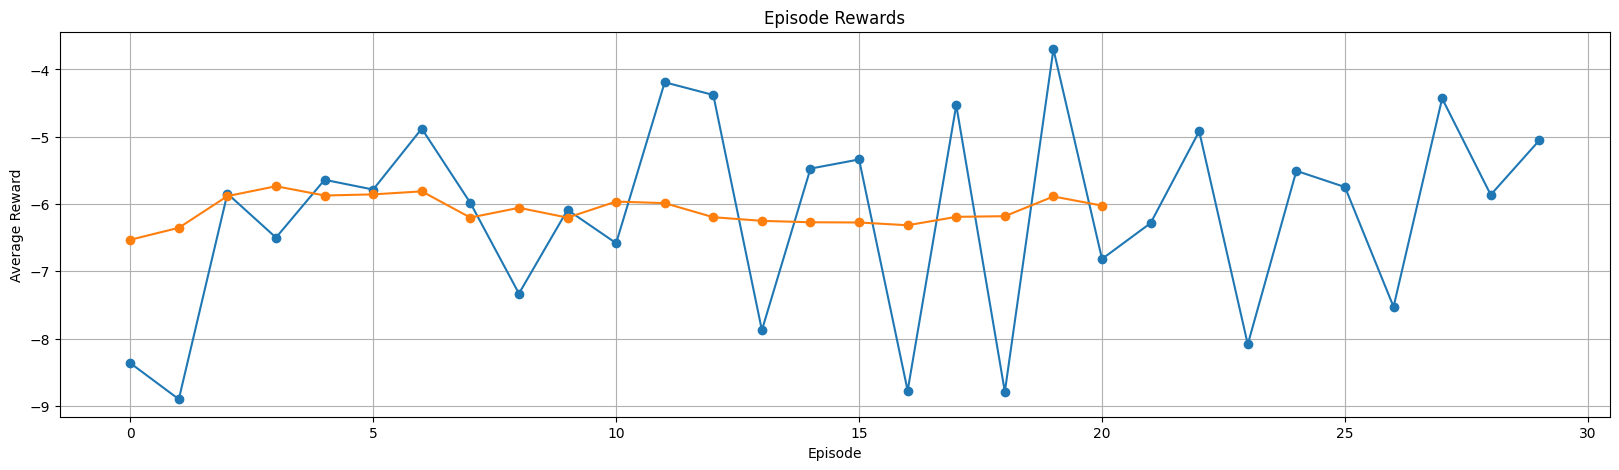

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


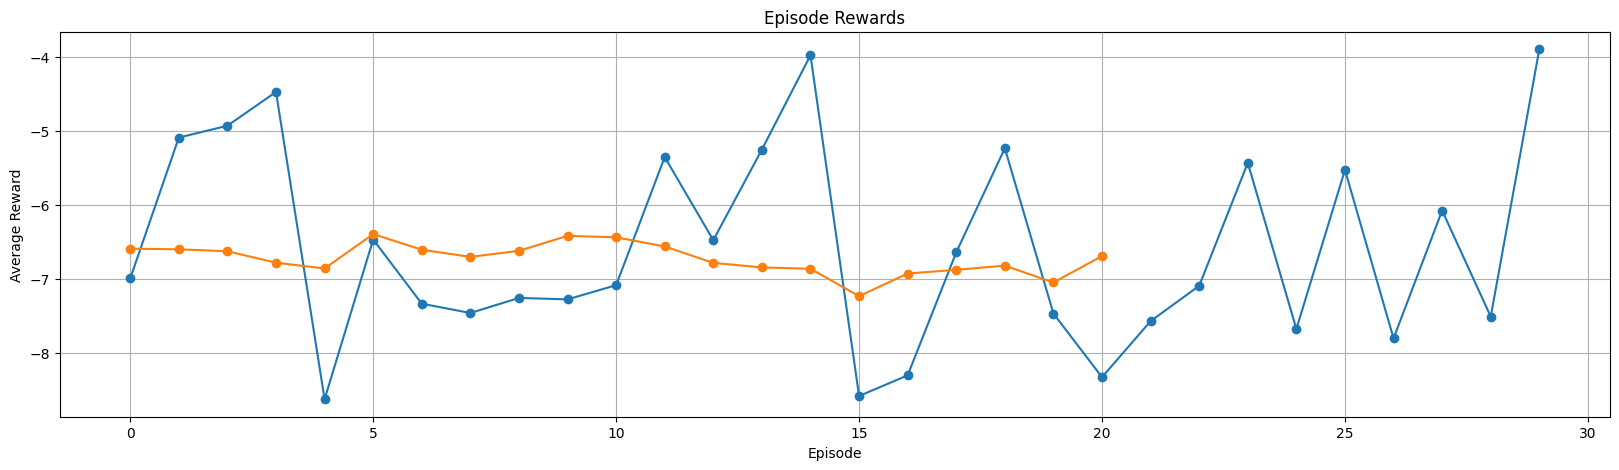

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


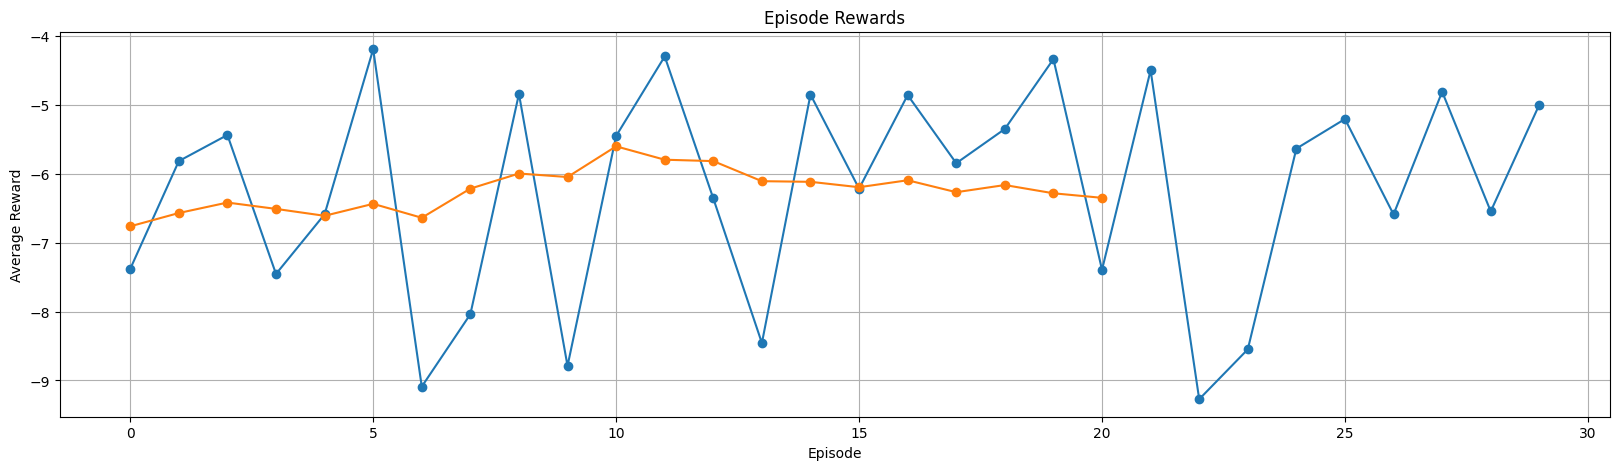

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


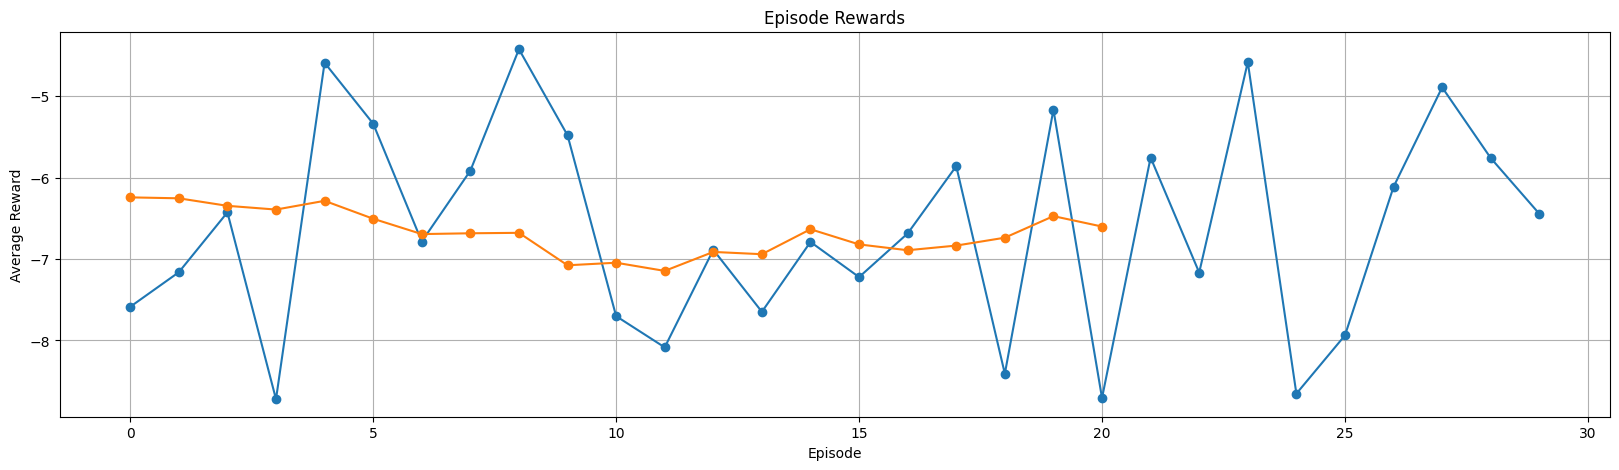

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,716 (22.33 KB)

 Trainable params: 5,716 (22.33 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


ValueError: in user code:

    File "C:\Users\adamt\AppData\Local\Temp\ipykernel_37988\3821669675.py", line 178, in GTfit  *
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 282, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 323, in apply
        self._check_variables_are_known(trainable_variables)
    File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\keras\src\optimizers\base_optimizer.py", line 228, in _check_variables_are_known
        raise ValueError(

    ValueError: Unknown variable: <KerasVariable shape=(3, 64), dtype=float32, path=1stHiddenLayer/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.


In [8]:
best_overall_reward = -np.inf
best_params = None
best_model_dir = None
average_rewards_dict = {}

for i in param_grid:
    env = gym.make(f'{EnvName}')
    env = Monitor(env, './pendulum_Videos', force=True)
    dqn = DQN(InputShape=InputShape, NActions=i['NActions'], optimizer=i['Optimizer'])
    tf.keras.backend.clear_session()
    dqn.reset_optimizer()
    print(dqn.optimizer)
    
    EPISODES = 30
    Epsilon = 1
    best_reward = -np.inf
    Epsilon_decay = i['Epsilon_decay']
    
    for episode in range(EPISODES):
        print(f'Episode {episode}')
        reward = OneEpisode(dqn, env)
        if Epsilon > Epsilon_min:
            Epsilon *= Epsilon_decay 
            print('Epsilon:', Epsilon)

        avg_reward = np.mean(reward)
        dqn.episode_rewards.append(np.sum(reward))
        dqn.average_rewards.append(avg_reward)
        print(f'Best reward so far: {best_reward}')

        if avg_reward > best_reward:
            best_reward = avg_reward
            dir_path = f"hypertune_{i['NActions']}_{i['Optimizer']}_{i['Epsilon_decay']}"
            dir_path = re.sub(r'[<>:"/\\|?*{}]', '_', dir_path)
            print(f'Saving best model weights for episode {episode} with reward {avg_reward}')
            dqn.save_weights(dir_path=dir_path)
            average_rewards_dict[dir_path] = avg_reward

            # Rename video file with the corresponding model name
            video_files = [f for f in os.listdir('./pendulum_Videos') if f.endswith('.mp4')]
            if video_files:
                latest_file = max(video_files, key=lambda x: os.path.getctime(os.path.join('./pendulum_Videos', x)))
                os.rename(os.path.join('./pendulum_Videos', latest_file), os.path.join('./pendulum_Videos', f"{dir_path}_{episode}.mp4"))
            
            # Update the best overall reward and parameters if necessary
            if best_reward > best_overall_reward:
                best_overall_reward = best_reward
                best_params = i
                best_model_dir = dir_path
    
    print(f'Average Rewards: {avg_reward}')
    dqn.plot_avg_rewards()

# After the loop, the best model and hyperparameters are stored in `best_params` and `best_model_dir`.
print(f'Best overall reward: {best_overall_reward} with parameters: {best_params}')
print(f'The best model is saved in: {best_model_dir}')


In [ ]:
# Plotting the average rewards for each hyperparameter set
plt.figure(figsize=(12, 8))
for param_str, avg_rewards in average_rewards_dict.items():
    plt.plot(avg_rewards, label=param_str)

plt.title('Average Rewards per Episode for Different Hyperparameters')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# best_overall_reward = -np.inf
# best_params = None
# best_model_dir = None

# for i in param_grid:
#     env = gym.make(f'{EnvName}')
#     env = Monitor(env,'./pendulum_Videos', force=True)
#     tf.keras.backend.clear_session()
#     dqn = DQN(InputShape = InputShape, NActions = i['NActions'], optimizer=i['Optimizer'], Gamma=i['Gamma'])
#     # dqn.load_weights(path='best_dqn_weights_hp_' + str(i))
    
#     EPISODES = 50
#     Epsilon = 1
#     best_reward = -5
#     avg_reward = []
#     Epsilon_decay=i['Epsilon_decay']
#     for _ in range(EPISODES):

#         print(f'Episode {_}')
#         reward = OneEpisode(dqn,env)
#         if Epsilon > Epsilon_min:
#             Epsilon *= Epsilon_decay 
#             print('Epsilon:',Epsilon)

#         dqn.episode_rewards.append(np.sum(reward))
#         dqn.average_rewards.append(np.mean(reward))
#         print(f'Best reward: {best_reward}')


#         if np.mean(reward) > best_reward:
#             best_reward = np.mean(reward)
#             # Create a valid filename string
#             dir_path = f"hypertune_{i['NActions']}_{i['Optimizer']}_{i['Gamma']}_{i['Epsilon_decay']}"
#             # Replace invalid characters with underscores or remove them
#             dir_path = re.sub(r'[<>:"/\\|?*{}]', '_', dir_path)
#             print(f'Saving best model weights for episode {_} with reward {np.mean(reward)}')
#             dqn.save_weights(dir_path=dir_path)
#             video_files = [f for f in os.listdir('./pendulum_Videos') if f.endswith('.mp4')]
#             if video_files:
#                 latest_file = max(video_files, key=lambda x: os.path.getctime(os.path.join('./pendulum_Videos', x)))
#                 os.rename(os.path.join('./pendulum_Videos', latest_file), os.path.join('./pendulum_Videos', f"{dir_path}_{_}.mp4"))
    

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,066 (19.79 KB)

 Trainable params: 5,066 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(20, 5))
# for history, name in zip(episode_rewards_list, name_list):
#     plt.plot(history, marker='o', label=name)
#     dqn.moving_average(history, 10)
# plt.title('Episode Rewards')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(20, 5))
# for history, name in zip(average_reward_list, name_list):
#     plt.plot(history, marker='o', label=name)
#     dqn.moving_average(history, 10)
# plt.title('Episode Rewards')
# plt.xlabel('Episode')
# plt.ylabel('average Reward')
# plt.grid(True)
# plt.legend()
# plt.show()
